Remember to change your jupyter kernel to `pytorch-tutorial`.

In [1]:
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm

# toy data: sklearn's moonshape dataset
from sklearn import datasets
from sklearn.model_selection import train_test_split

We first check our configuration, you should see we are using NVIDIA GeForce RTX 4090 if you are using Prof. Chern's computer.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    print("using", torch.cuda.get_device_name(0))
else:
    print("CUDA unavailable, using CPU")

using NVIDIA GeForce RTX 4090


In [3]:
# creaet toy dataset
moon_data, moon_label = datasets.make_moons(n_samples=1000, noise=0.2)
print("data shape:", moon_data.shape)  # 2-dimensional
print("label shape:", moon_label.shape)

data shape: (1000, 2)
label shape: (1000,)


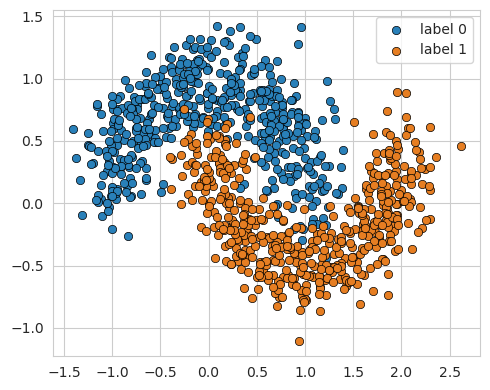

In [4]:
# visualize
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
kwargs = {"edgecolors" : "black", "linewidths" : 0.5}
ax.scatter(moon_data[np.where(moon_label[:] == 0), 0], moon_data[np.where(moon_label[:] == 0), 1], color="#2980B9", label="label 0", **kwargs)
ax.scatter(moon_data[np.where(moon_label[:] == 1), 0], moon_data[np.where(moon_label[:] == 1), 1], color="#E67E22", label="label 1", **kwargs)
ax.legend(loc="upper right")
fig.tight_layout()
fig.show()

In [5]:
# split train test with ratio 8:2
train_data, test_data, train_label, test_label = train_test_split(moon_data, moon_label, test_size=0.2)
print("train data shape:", train_data.shape)
print("train label shape:", train_label.shape)
print("test data shape:", test_data.shape)
print("test label shape:", test_label.shape)

train data shape: (800, 2)
train label shape: (800,)
test data shape: (200, 2)
test label shape: (200,)


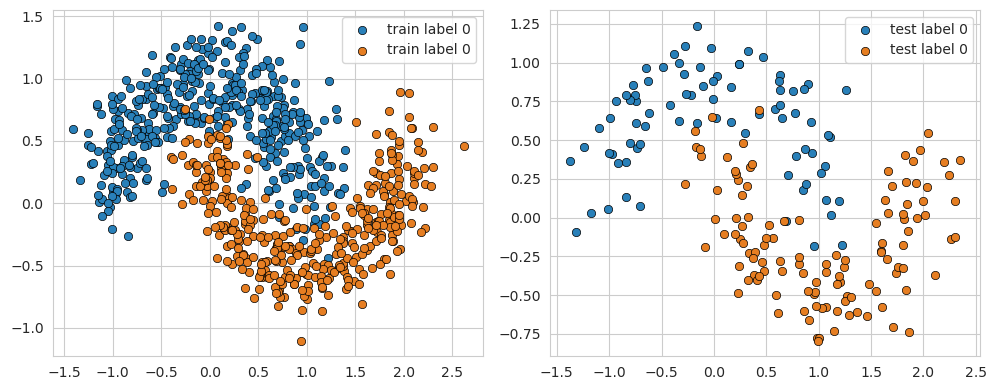

In [6]:
# visualize
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
kwargs = {"edgecolors" : "black", "linewidths" : 0.5}
ax[0].scatter(train_data[np.where(train_label[:] == 0), 0], train_data[np.where(train_label[:] == 0), 1], color="#2980B9", label="train label 0", **kwargs)
ax[0].scatter(train_data[np.where(train_label[:] == 1), 0], train_data[np.where(train_label[:] == 1), 1], color="#E67E22", label="train label 0", **kwargs)
ax[0].legend(loc="upper right")
ax[1].scatter(test_data[np.where(test_label[:] == 0), 0], test_data[np.where(test_label[:] == 0), 1], color="#2980B9", label="test label 0", **kwargs)
ax[1].scatter(test_data[np.where(test_label[:] == 1), 0], test_data[np.where(test_label[:] == 1), 1], color="#E67E22", label="test label 0", **kwargs)
ax[1].legend(loc="upper right")
fig.tight_layout()
fig.show()

In [7]:
# hyperparameters
class Params:
    def __init__(self):
        self.num_epochs = 100
        self.early_stop = 10
        self.batch_size = 8
        self.learn_rate = 0.001
params = Params()

In [8]:
# create dataloader
train_data = torch.from_numpy(train_data).float()
train_label = torch.from_numpy(train_label).float()
test_data = torch.from_numpy(test_data).float()
test_label = torch.from_numpy(test_label).float()

train_dataset = TensorDataset(train_data, train_label)
test_dataset =  TensorDataset(test_data, test_label)
# split train validation with ratio 6:2
train_dataset, valid_dataset = random_split(train_dataset,[600, 200])
train_loader = DataLoader(dataset=train_dataset, batch_size=params.batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=params.batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=params.batch_size, shuffle=False)

In [9]:
# define model, loss, and optimizer
class MlpModel(torch.nn.Module):
    def __init__(self):
        super(MlpModel, self).__init__()
        # define your layers here
        self.layer1 = torch.nn.Sequential(
            torch.nn.Linear(2, 32), 
            torch.nn.ReLU(),
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Linear(32, 16), 
            torch.nn.ReLU(),
        )
        self.layer3 = torch.nn.Linear(16, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x): 
        # construct your model here
        x = self.layer1(x)
        # you can also write it together
        x = self.layer3(self.layer2(x))
        x = self.sigmoid(x)
        return x

model = MlpModel().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=params.learn_rate)    
print(model)


MlpModel(
  (layer1): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
  )
  (layer3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [10]:
class Logger:
    def __init__(self, num_epochs):
        self.train_loss_list = []
        self.valid_loss_list = []
        self.train_acc_list = []
        self.valid_acc_list = []
        self.early_stop = num_epochs

    def write_loss(self, train_loss, valid_loss):
        self.train_loss_list.append(train_loss)
        self.valid_loss_list.append(valid_loss)

    def write_acc(self, train_acc, valid_acc):
        self.train_acc_list.append(train_acc)
        self.valid_acc_list.append(valid_acc)

def compute_accuracy(output, label, gpu=True, grad=False):
    if gpu:
        output = output.cpu()
        label = label.cpu()
    if grad:
        output = output.detach()

    predict_label = np.where(output.numpy() < 0.5, 0, 1)
    label = label.numpy()
    return np.mean(predict_label == label)


In [11]:
# train model
early_step = 0
min_valid_loss = 1e10
logger = Logger(params.num_epochs)

for epoch in range(params.num_epochs):    
    train_acc, valid_acc = 0.0, 0.0 
    train_loss, valid_loss = 0.0, 0.0
    # train
    for data, label in tqdm(train_loader, desc="Train [{:2d}/{}]".format(epoch+1, params.num_epochs), unit="batch"):
        # use CUDA if available
        data = data.to(device)
        label = label.to(device)
        # compute output and loss
        output = model(data).squeeze()
        loss = criterion(output, label) 
        # update model weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # update train loss and accuracy
        train_loss += loss.item()
        train_acc += compute_accuracy(output, label, grad=True)
    # validation
    model.eval()
    with torch.no_grad():
        for data, label in tqdm(valid_loader, desc="Valid [{:2d}/{}]".format(epoch+1, params.num_epochs), unit="batch"):
            # use CUDA if available
            data = data.to(device)
            label = label.to(device)
            # compute output and loss
            output = model(data).squeeze() 
            loss = criterion(output, label) 
            # update validation loss and accuracy
            valid_loss += loss.item()
            valid_acc += compute_accuracy(output, label)

    logger.write_loss(train_loss / len(train_loader), valid_loss / len(valid_loader))
    logger.write_acc(train_acc / len(train_loader), valid_acc / len(valid_loader))

    # early stop
    if min_valid_loss > valid_loss: 
        early_step = 0
        min_valid_loss = valid_loss 
        os.makedirs("checkpoints", exist_ok=True)   
        torch.save(model.state_dict(),"checkpoints/model.pth")
    else:
        early_step += 1
        if early_step >= params.early_stop:
            logger.early_stop = epoch - params.early_stop
            print("No improvements for {} consecutive epochs".format(params.early_stop))
            break

Valid [55/100]: 100%|██████████| 25/25 [00:00<00:00, 5982.29batch/s]

No improvements for 10 consecutive epochs


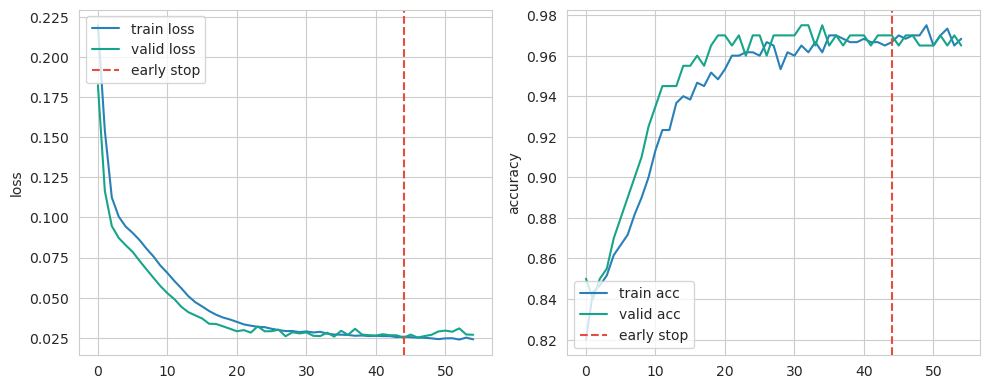

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(logger.train_loss_list, color="#2980B9", label="train loss")
ax[0].plot(logger.valid_loss_list, color="#17A589", label="valid loss")
ax[0].axvline(x=logger.early_stop, color="#E74C3C", linestyle='--', label="early stop")
ax[0].set_ylabel('loss')
ax[0].legend(loc="upper left")
ax[1].plot(logger.train_acc_list, color="#2980B9", label="train acc")
ax[1].plot(logger.valid_acc_list, color="#17A589", label="valid acc")
ax[1].set_ylabel('accuracy')
ax[1].axvline(x=logger.early_stop, color="#E74C3C", linestyle='--', label="early stop")
ax[1].legend(loc="lower left")
fig.tight_layout()
fig.show()

In [13]:
# inference
model = MlpModel().to(device)
model.load_state_dict(torch.load("checkpoints/model.pth"))
model.eval()  

test_acc = 0.0
with torch.no_grad():
    for data, label in tqdm(test_loader, desc="Test", unit="batch"):
        data = data.to(device)
        label = label.to(device)
        output = model(data).squeeze() 
        test_acc += compute_accuracy(output, label)
    test_acc /= len(test_loader)

print("\nTest Accuracy {:.2f}%".format(100 * test_acc))

Test: 100%|██████████| 25/25 [00:00<00:00, 6487.51batch/s]


Test Accuracy 97.00%


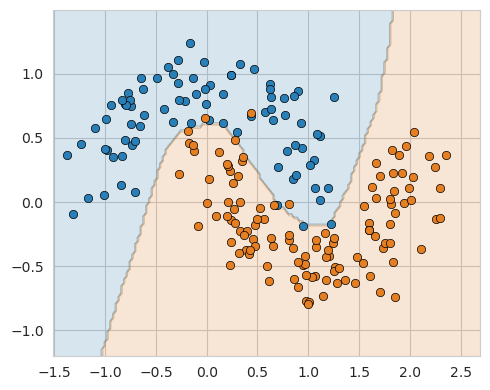

In [14]:
# visualize
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#2980B9", "#E67E22"])

x_min, x_max = moon_data[:, 0].min() - 0.1, moon_data[:, 0].max() + 0.1
y_min, y_max = moon_data[:, 1].min() - 0.1, moon_data[:, 1].max() + 0.1
grid = min(x_max - x_min, y_max - y_min) / 100

XX, YY = np.meshgrid(np.arange(x_min, x_max, grid), np.arange(y_min, y_max, grid))
meshgrid_ = np.hstack((XX.ravel().reshape(-1,1), YY.ravel().reshape(-1,1)))
meshgrid_features = torch.from_numpy(meshgrid_).float().to(device)
meshgrid_colors = model(meshgrid_features)
clf = np.where(meshgrid_colors.cpu() < 0.5, 0,1)
ZZ = clf.reshape(XX.shape)

# transfer tensor back to numpy
test_data = test_data.numpy()
test_label = test_label.numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.contourf(XX, YY, ZZ, cmap=cmap, alpha=0.2)
kwargs = {"edgecolors" : "black", "linewidths" : 0.5}
ax.scatter(test_data[np.where(test_label[:] == 0), 0], test_data[np.where(test_label[:] == 0), 1], color="#2980B9", **kwargs)
ax.scatter(test_data[np.where(test_label[:] == 1), 0], test_data[np.where(test_label[:] == 1), 1], color="#E67E22", **kwargs)
fig.tight_layout()
fig.show()